Анастасия Плавина

## Модель предсказания невыполнения клиентом долговых обязательств

**Цель проекта**: обучить модель предсказания невыполнения долговых обязательств клиентом по текущему кредиту на основе данных о клиенте банка.

**Метрика качества**: F1-score - метрика, показывающая гармоническое среднее между показателями precision и recall. В качестве baseline принимается значение 0.5

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.metrics import f1_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestClassifier

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

%matplotlib inline

### 1. Обзор датасета

**Целевая переменная**
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



**Независимые переменные:**
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка кредитоспособности


### 2. Загрузка данных

In [2]:
train_path = 'course_project_train.csv'
test_path = 'course_project_test.csv'

In [3]:
df = pd.read_csv(train_path)
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df.shape

(7500, 17)

In [5]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 3. Обзор целевой переменной

In [6]:
target_name = 'Credit Default'
features_names = df.columns.drop(target_name).tolist()

Соотношение целевой переменной
0 (погашение) - 72%
1 (просрочка) - 28%


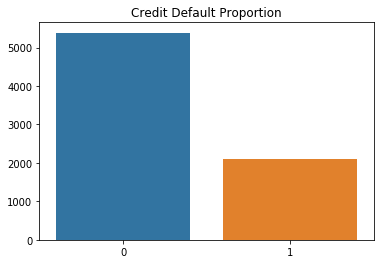

In [7]:
counts = df[target_name].value_counts()

print('Соотношение целевой переменной')
print(f'0 (погашение) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (просрочка) - {counts[1]/df.shape[0]*100:.0f}%')


plt.figure(figsize=(6,4))    
plt.title('Credit Default Proportion')
sns.barplot(counts.index, counts.values)
plt.show()

### 4. Обзор признаков

In [8]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### 4.1 Категориальные признаки

In [9]:
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [10]:
# создание колонки с преобразованными в числа сроками работы на текущем месте работы клиента
df['Years_in_cur_job_int'] = 10
 
df.loc[df['Years in current job'] == '< 1 year', 'Years_in_cur_job_int'] = 0  
df.loc[df['Years in current job'] == '1 year', 'Years_in_cur_job_int'] = 1
df.loc[df['Years in current job'] == '2 years', 'Years_in_cur_job_int'] = 2  
df.loc[df['Years in current job'] == '3 years', 'Years_in_cur_job_int'] = 3
df.loc[df['Years in current job'] == '4 years', 'Years_in_cur_job_int'] = 4 
df.loc[df['Years in current job'] == '5 years', 'Years_in_cur_job_int'] = 5
df.loc[df['Years in current job'] == '6 years', 'Years_in_cur_job_int'] = 6
df.loc[df['Years in current job'] == '7 years', 'Years_in_cur_job_int'] = 7 
df.loc[df['Years in current job'] == '8 years', 'Years_in_cur_job_int'] = 8
df.loc[df['Years in current job'] == '9 years', 'Years_in_cur_job_int'] = 9 
df.loc[df['Years in current job'] == '10+ years', 'Years_in_cur_job_int'] = 10   

In [11]:
cat_features_names = ['Home Ownership', 'Years_in_cur_job_int', 'Bankruptcies', 'Number of Credit Problems', 
                     'Purpose', 'Term', 'Tax Liens']

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************



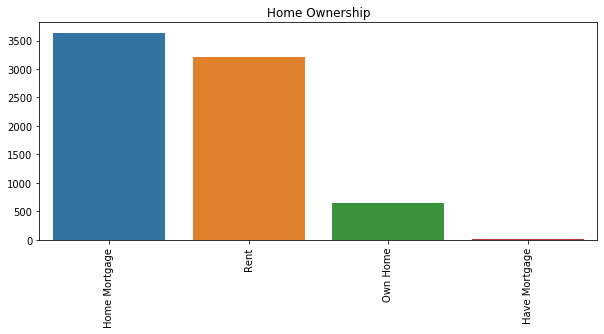

Years_in_cur_job_int

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years_in_cur_job_int, dtype: int64
****************************************************************************************************



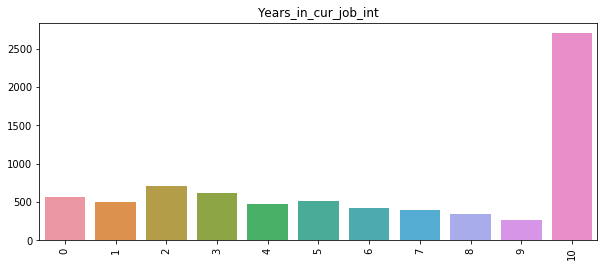

Bankruptcies

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
****************************************************************************************************



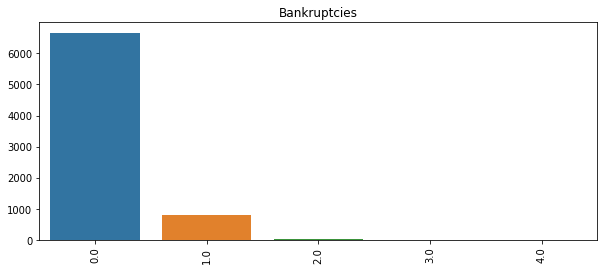

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
****************************************************************************************************



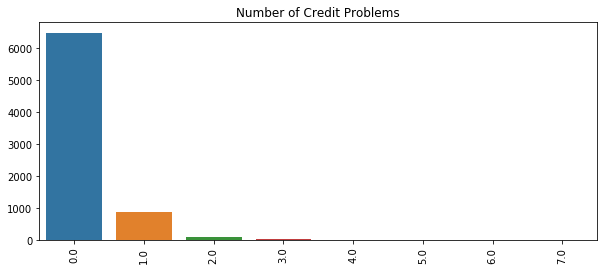

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************



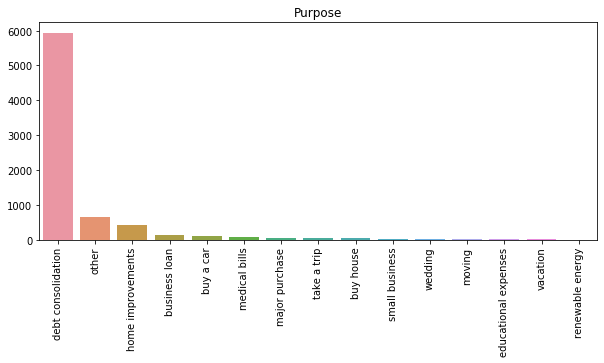

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



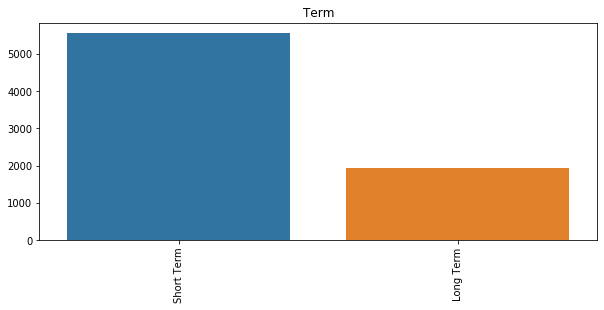

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************



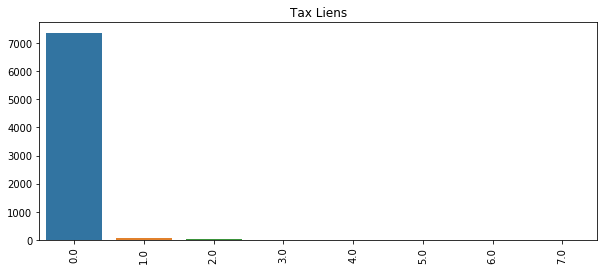

In [12]:
for cat_colname in cat_features_names:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    counts = df[cat_colname].value_counts()
    plt.figure(figsize=(10,4))    
    plt.title(cat_colname)
    plt.xticks(rotation=90)
    sns.barplot(counts.index, counts.values)
    plt.show()

#### 4.2. Обзор количественных признаков

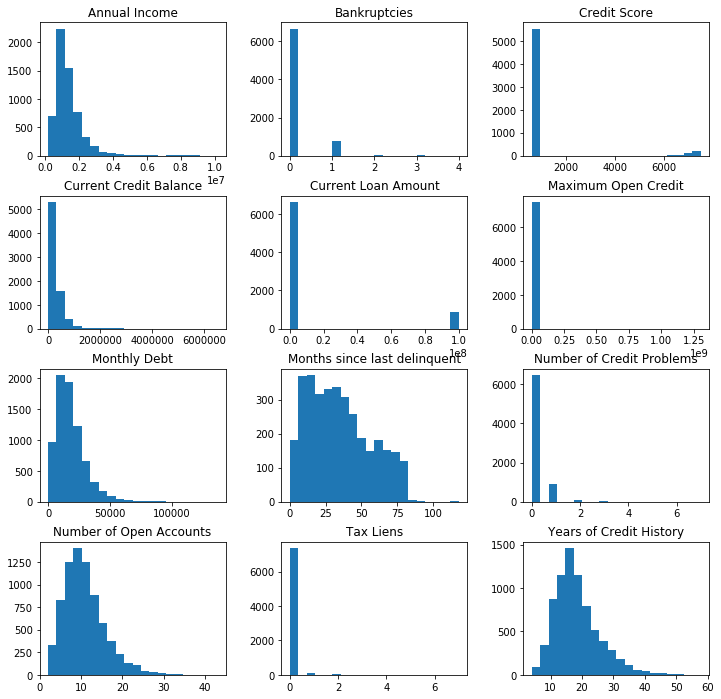

In [13]:
df_num_features =  df.select_dtypes(exclude=['object', 'int'])

df_num_features.hist(figsize=(12,12), bins=20, grid=False)
plt.show()

### 5. Обработка пропусков и выбросов

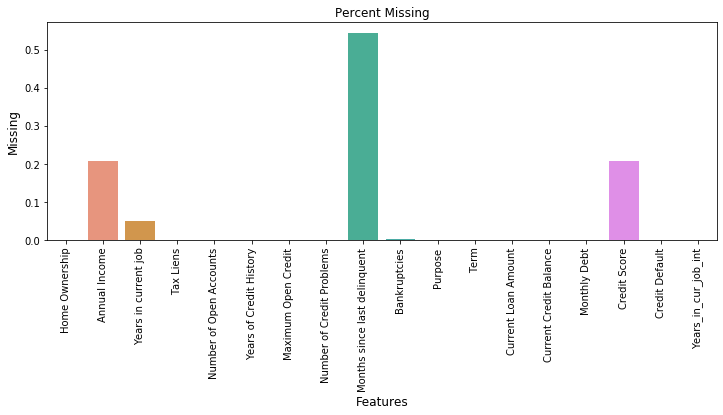

In [14]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [15]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = 1000000

In [16]:
# создание ID
df['ID'] = df.index.tolist()

# преобразование бинарных признаков
df['Term_bool'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [17]:
df['Annual Income'].fillna(df['Annual Income'].mode()[0], inplace=True)
df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)
df['Annual Income'].fillna(df['Annual Income'].mode()[0], inplace=True)
df['Credit Score'].fillna(df['Credit Score'].mode()[0], inplace=True)

In [18]:
# для клиентов, у которых не было проблем по кредиту, заполняем на -1 пропуски в графе кол-во месяцев с просрочки
# последнего платежа, заполняем пропуски в Bankruptcies нулями, если не было проблем по кредиту

df.loc[(df['Number of Credit Problems'] == 0) & (df['Months since last delinquent'].isna()), 'Months since last delinquent'] = -1
df.loc[(df['Number of Credit Problems'] == 0) & (df['Bankruptcies'].isna()), 'Bankruptcies'] = 0

In [19]:
# остальные пропуски заполняем модой

df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0], inplace=True)
df['Months since last delinquent'].fillna(df['Months since last delinquent'].mode()[0], inplace=True)

In [20]:
# обрабатываем выбросы в Credit Score

df.loc[df['Credit Score'] > 850, 'Credit Score'] = df.loc[df['Credit Score'] > 850, 'Credit Score']/10

### 6. Проверка гипотез и отбор признаков

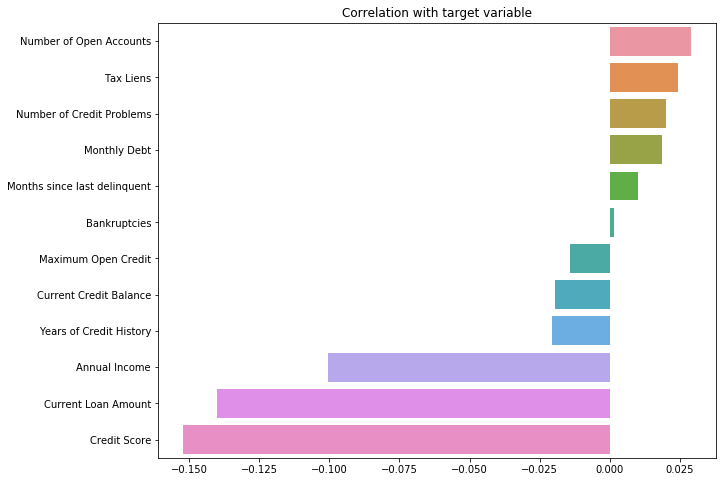

In [21]:
corr_with_target = df[features_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

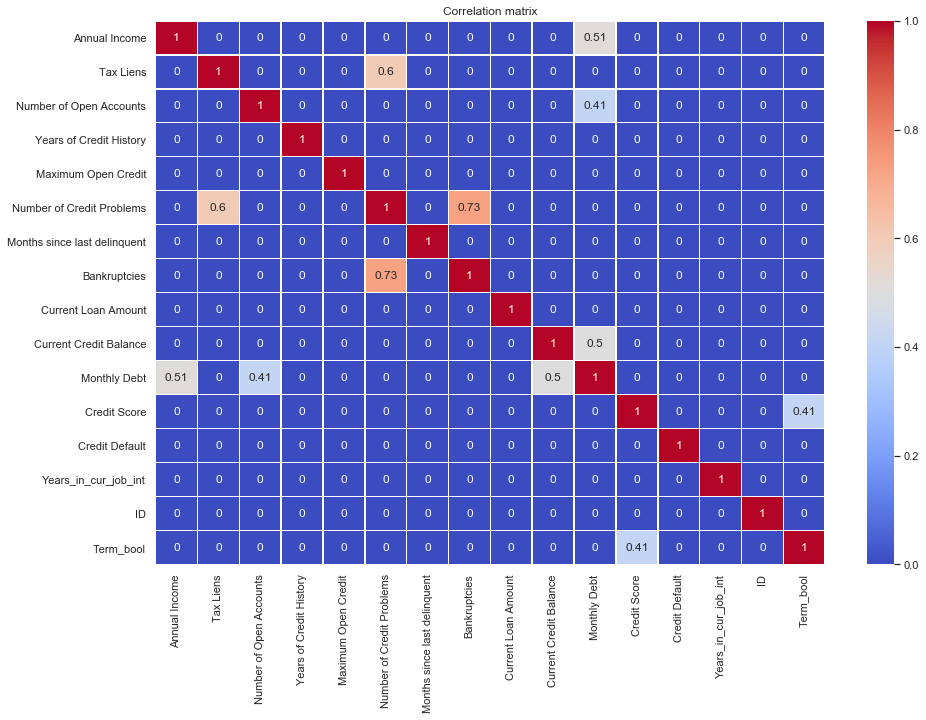

In [22]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1)


corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Выводы по корреляционной матрице:**

1. Наблюдается наибольшая корреляция таргета с показателем Credit Score.
2. Количество ситуаций, когда клиент объявляет о банкротстве, коррелирует с количеством проблем по кредиту.
3. Количество проблем по кредитам, в свою очередь, коррелирует с уровнем налоговых обременений.
4. Месячный долг демонстрирует корреляцию с годовым доходом, количеством открытых счетов и текущим остатком по кредиту.

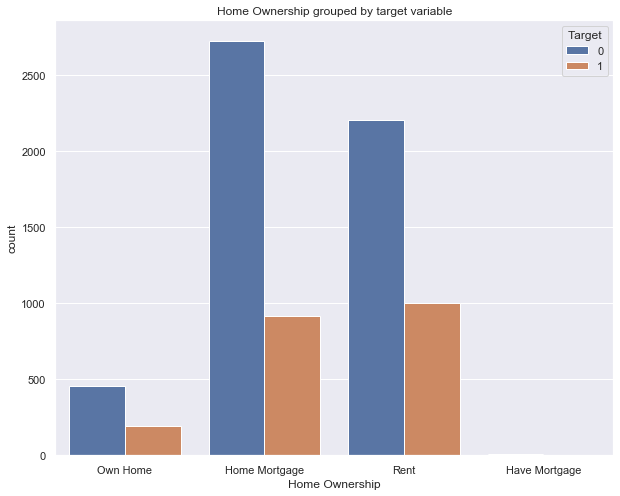

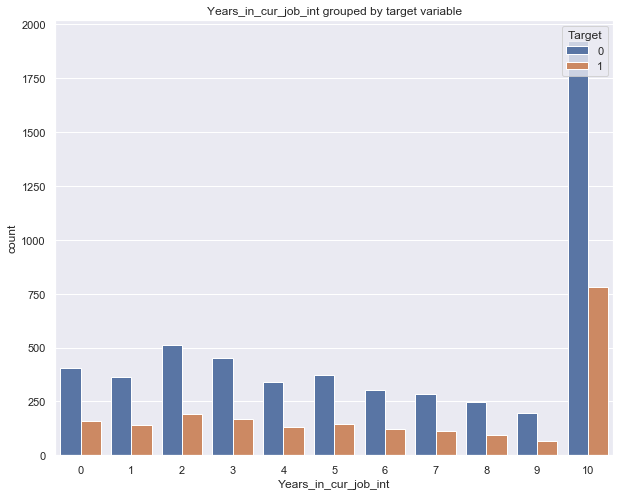

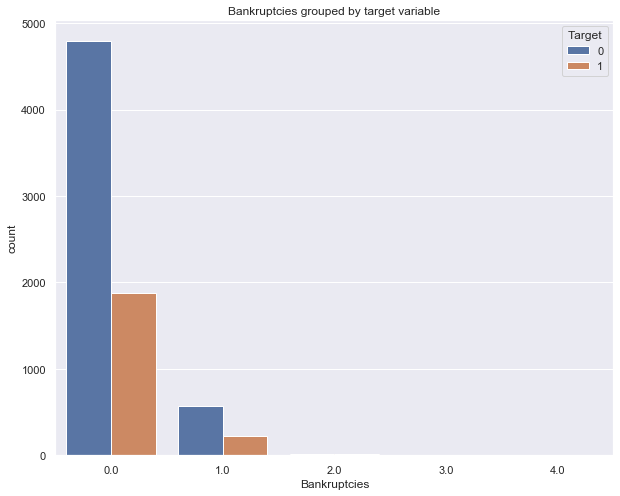

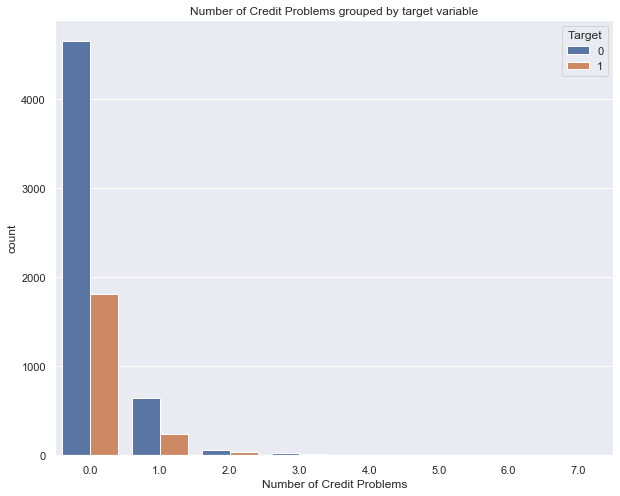

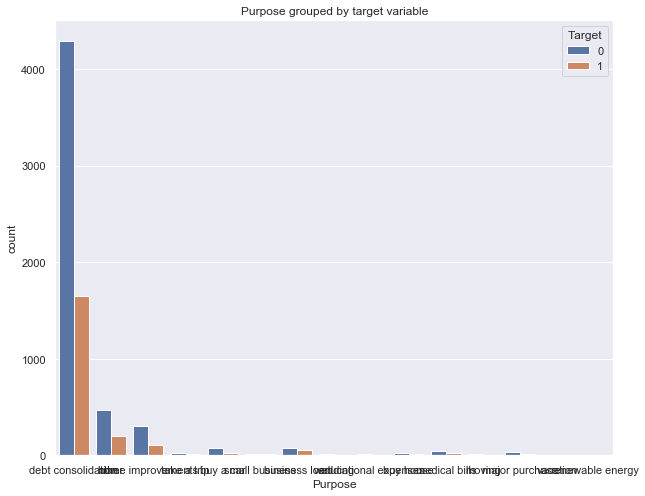

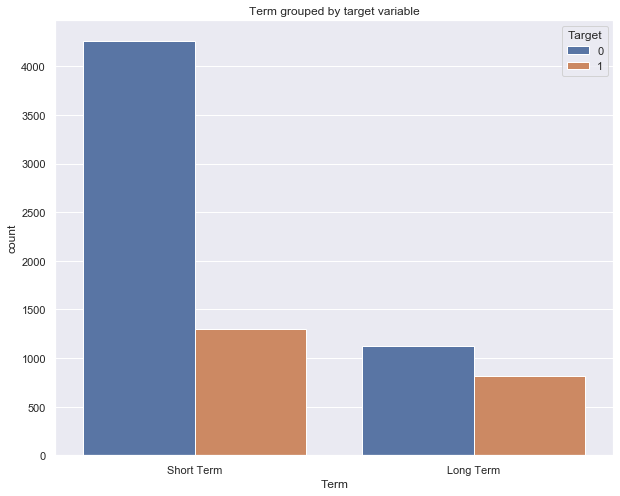

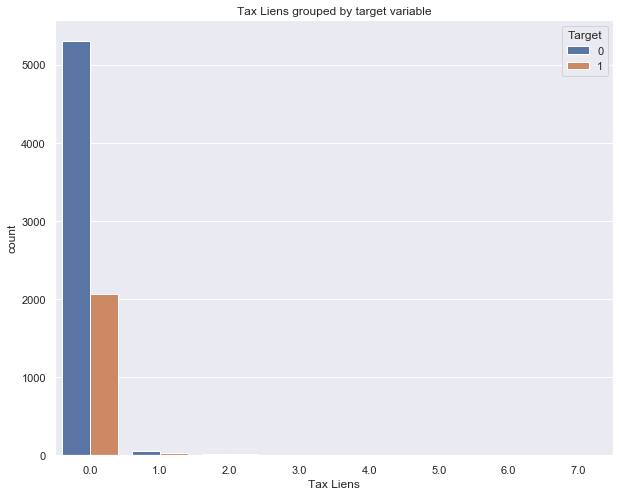

In [23]:
for name in cat_features_names:

    plt.figure(figsize=(10, 8))

    sns.countplot(x=name, hue=target_name, data=df)
    plt.title(f'{name} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

In [24]:
def contingency_test(df, feature):
    feat_values = df[feature].unique()

    for item in itertools.combinations(feat_values, 2):
        if df[df[feature]==item[0]].shape[0] < 500 and df[df[feature]==item[1]].shape[0] < 500:
            continue
        feature_and_target_s = df.loc[df[feature].isin(list(item)), \
                                         ['ID', feature, target_name]].sample(500)

        table = feature_and_target_s.pivot_table(values='ID', index=feature, columns=target_name, 
                                                        aggfunc='count')
        
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        
        if p != p: # если nan
            continue
        if p > 0.05:
            print(f'{item}, p={p:.2f}, частоты согласованы')
        
            df.loc[df[feature]==item[0], feature] = item[1]


Проверим гипотезы о согласованности частот в разных категориях категориальных признаков.

**Нулевая гипотеза:** ожидаемые и наблюдаемые частоты согласованы

**Альтернативная гипотеза:** отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы

**Критерий:** Хи-квадрат Пирсона

**Уровень значимости  𝛼 :** 0.05

**Критическая область:** двухсторонняя

Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [25]:
for col in cat_features_names:
    print(f'---------------------------{col}--------------------')
    contingency_test(df, col)

---------------------------Home Ownership--------------------
('Own Home', 'Home Mortgage'), p=0.72, частоты согласованы
('Own Home', 'Rent'), p=1.00, частоты согласованы
('Home Mortgage', 'Rent'), p=0.46, частоты согласованы
('Rent', 'Have Mortgage'), p=1.00, частоты согласованы
---------------------------Years_in_cur_job_int--------------------
(10, 8), p=0.90, частоты согласованы
(10, 5), p=1.00, частоты согласованы
(10, 1), p=1.00, частоты согласованы
(10, 0), p=1.00, частоты согласованы
(10, 3), p=1.00, частоты согласованы
(10, 2), p=1.00, частоты согласованы
(8, 6), p=0.32, частоты согласованы
(8, 5), p=1.00, частоты согласованы
(8, 1), p=1.00, частоты согласованы
(8, 0), p=1.00, частоты согласованы
(8, 3), p=1.00, частоты согласованы
(8, 2), p=1.00, частоты согласованы
(6, 7), p=0.08, частоты согласованы
(6, 5), p=1.00, частоты согласованы
(6, 1), p=1.00, частоты согласованы
(6, 0), p=1.00, частоты согласованы
(6, 3), p=1.00, частоты согласованы
(6, 2), p=1.00, частоты согласова

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/contingency.py:244: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


(3.0, 2.0), p=0.48, частоты согласованы
(2.0, 6.0), p=1.00, частоты согласованы
(6.0, 4.0), p=1.00, частоты согласованы
(4.0, 5.0), p=1.00, частоты согласованы
(5.0, 7.0), p=1.00, частоты согласованы
---------------------------Purpose--------------------
('debt consolidation', 'other'), p=0.06, частоты согласованы
('other', 'home improvements'), p=0.17, частоты согласованы
('home improvements', 'take a trip'), p=1.00, частоты согласованы
('take a trip', 'buy a car'), p=0.51, частоты согласованы
('buy a car', 'small business'), p=1.00, частоты согласованы
('small business', 'business loan'), p=0.42, частоты согласованы
('business loan', 'wedding'), p=1.00, частоты согласованы
('wedding', 'educational expenses'), p=1.00, частоты согласованы
('educational expenses', 'buy house'), p=0.53, частоты согласованы
('buy house', 'medical bills'), p=0.14, частоты согласованы
('medical bills', 'moving'), p=1.00, частоты согласованы
('moving', 'renewable energy'), p=1.00, частоты согласованы
-------

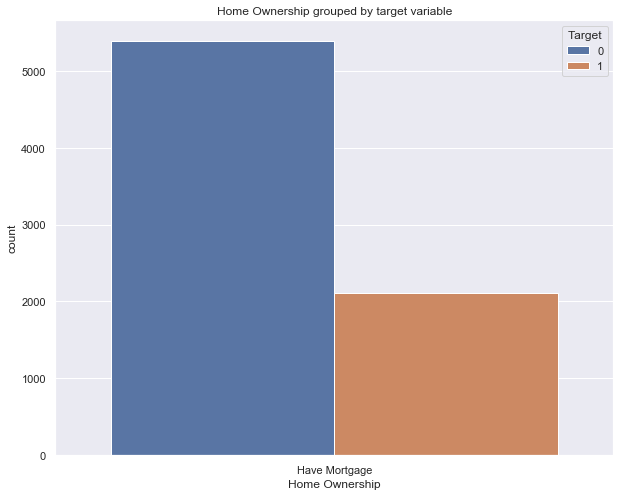

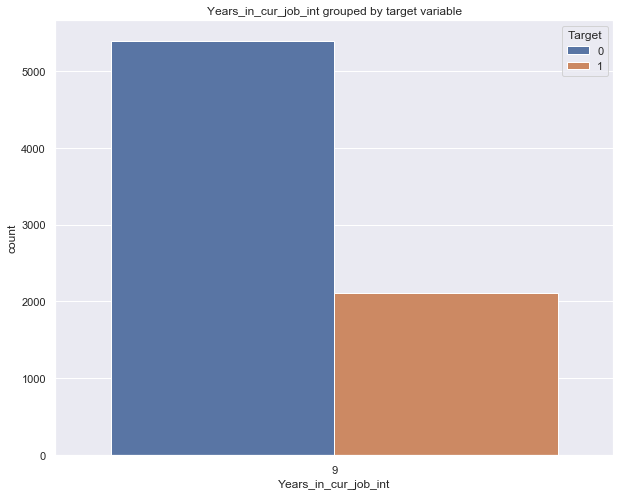

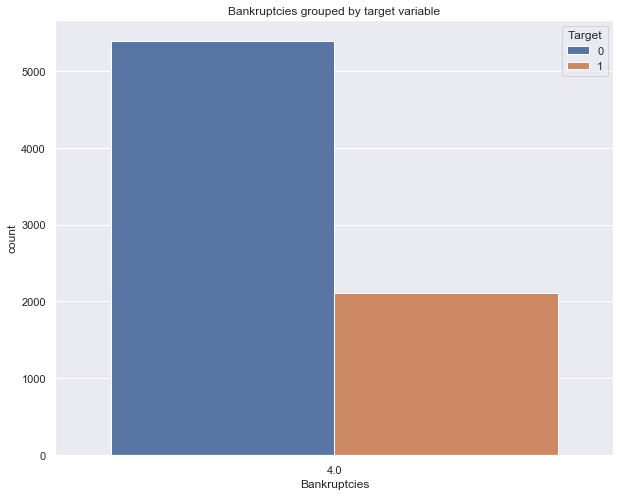

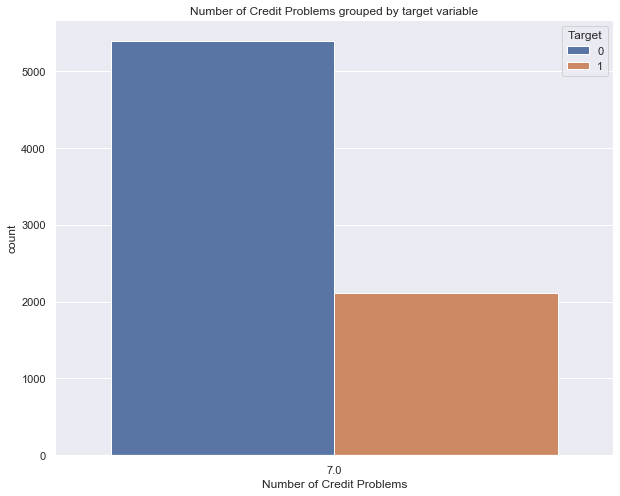

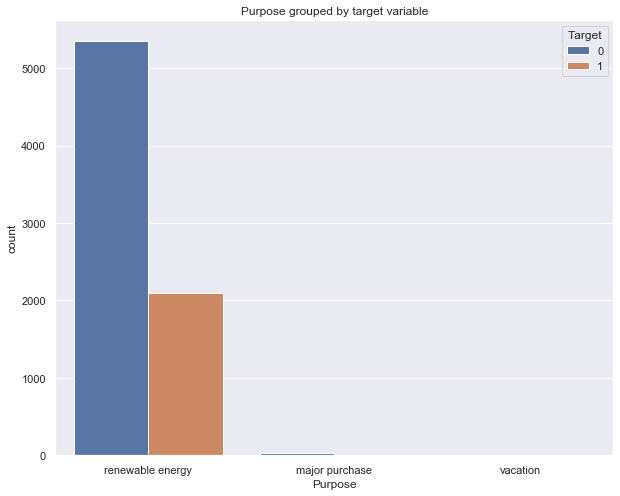

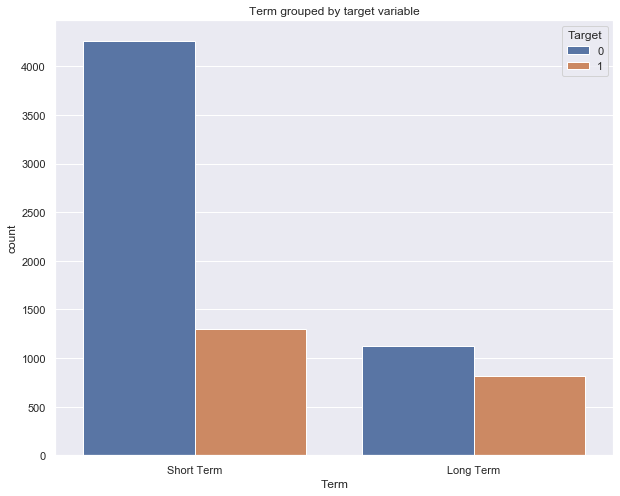

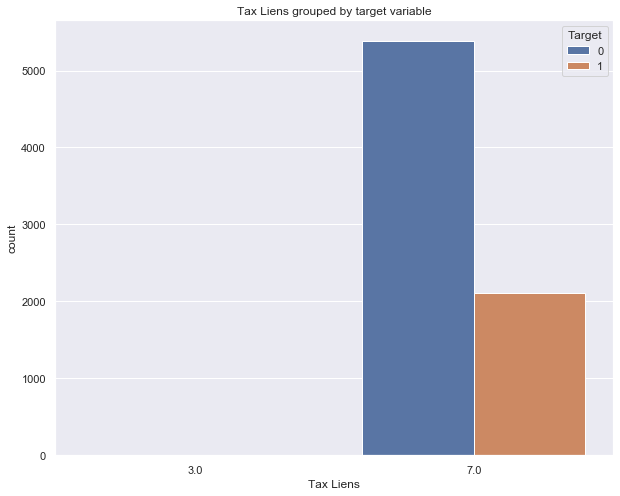

In [26]:
for name in cat_features_names:

    plt.figure(figsize=(10, 8))

    sns.countplot(x=name, hue=target_name, data=df)
    plt.title(f'{name} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

#### 7. Гипотезы о количественных признаках

In [27]:
def dist_checker(df, feature):

    
    feature_with_target_s = df[[feature, target_name]].sample(1000)
    feature_s = feature_with_target_s[feature]
    feature_target_0 = feature_s[feature_with_target_s[target_name] == 0]
    feature_target_1 = feature_s[feature_with_target_s[target_name] == 1]
    norm_test = shapiro(feature_s)[1]
    # проверяем на нормальность
    if norm_test > 0.05:
        print('Distribution is normal')
    else:
        print('Distribution is not normal')
        u_test = mannwhitneyu(feature_target_0, feature_target_1)[1]
        if u_test > 0.05:
            print('H0 нельзя отвергнуть, считаем, что мат.ожидания равны')
        else:
            print('H0 нельзя принять, считаем, что мат.ожидания не равны')
            

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    sns.kdeplot(feature_target_0, shade=True, label='No default', color='g', ax=axes[0])
    sns.kdeplot(feature_target_1, shade=True, label='Default', color='r', ax=axes[0])
    plt.xlabel(f'{feature}')
    plt.title(f'{feature} distribution grouped by target variable')
    
    
    sns.pointplot(x=target_name, y=feature, data=feature_with_target_s, capsize=.1, ax=axes[1])
    plt.title(f'Confidence intervals (95 %) for {feature}')

    
    
    plt.show()

In [28]:
num_features = ['Annual Income','Number of Open Accounts',
               'Years of Credit History', 'Maximum Open Credit','Months since last delinquent',
                'Current Loan Amount', 'Current Credit Balance',
               'Monthly Debt', 'Credit Score']

Проверим соотношение распределений количественных переменных в зависимости от значения таргета.

**Нулевая гипотеза:** средние значения в двух независимых выборках равны

**Альтернативная гипотеза:** средние значения в двух независимых выборках различаются

**Критерий:** проверка нормальности при помощи Шапиро-Уилка, далее в случае ненормальности распределения будем использовать критерий Манна-Уитни

**Уровень значимости**  𝛼 : 0.05

**Критическая область:** двухсторонняя


---------------------------Annual Income--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


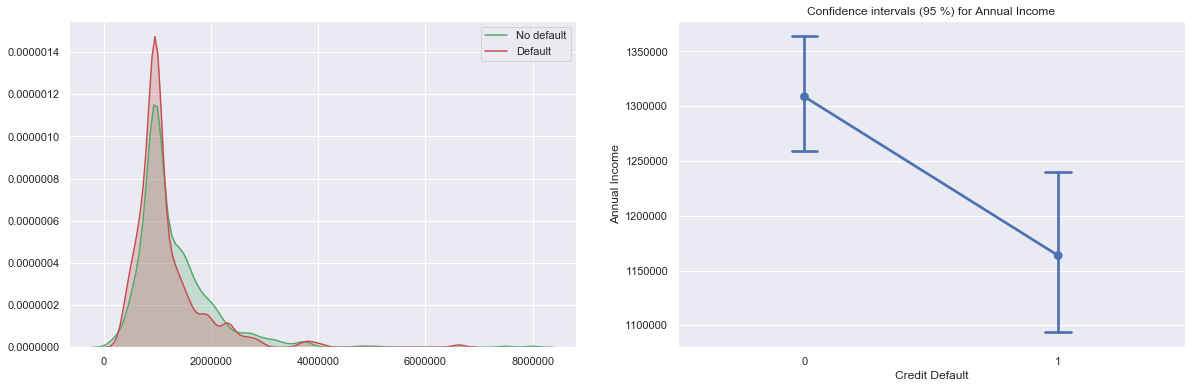

---------------------------Number of Open Accounts--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


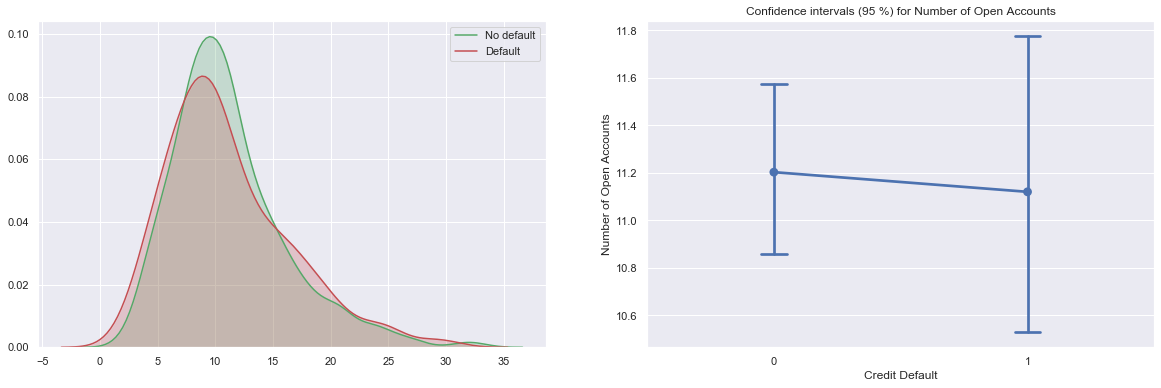

---------------------------Years of Credit History--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


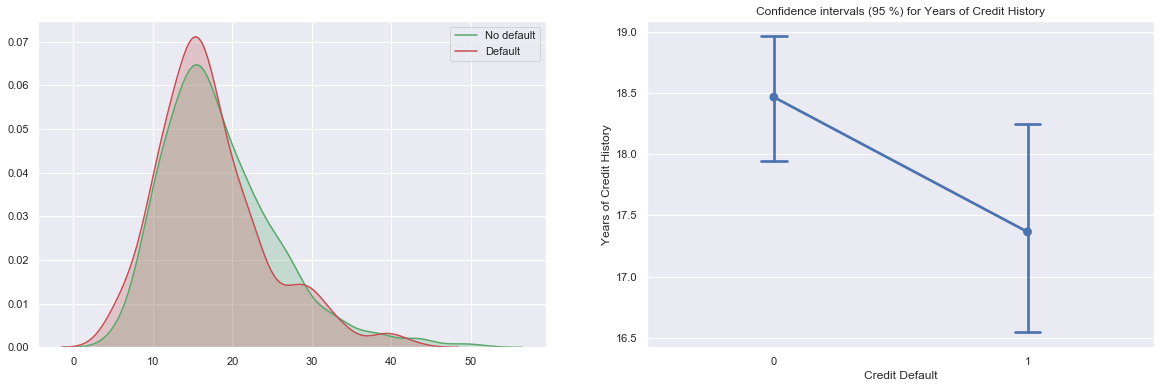

---------------------------Maximum Open Credit--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


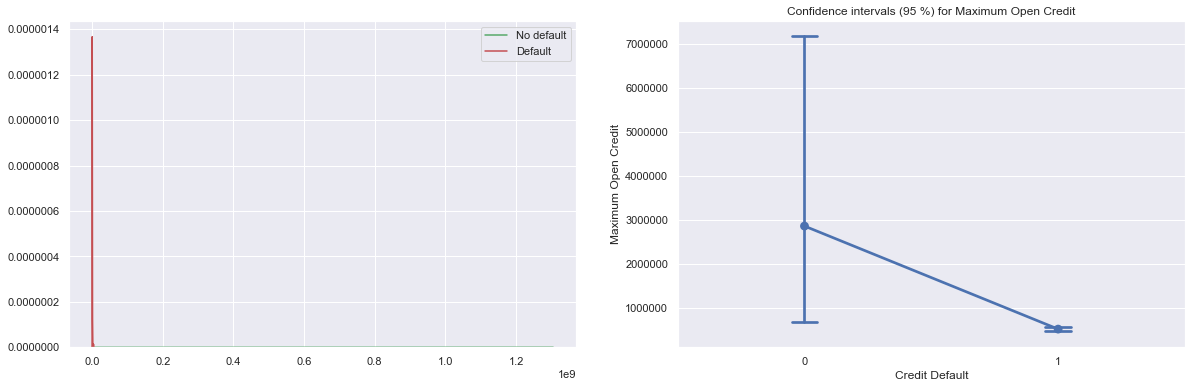

---------------------------Months since last delinquent--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


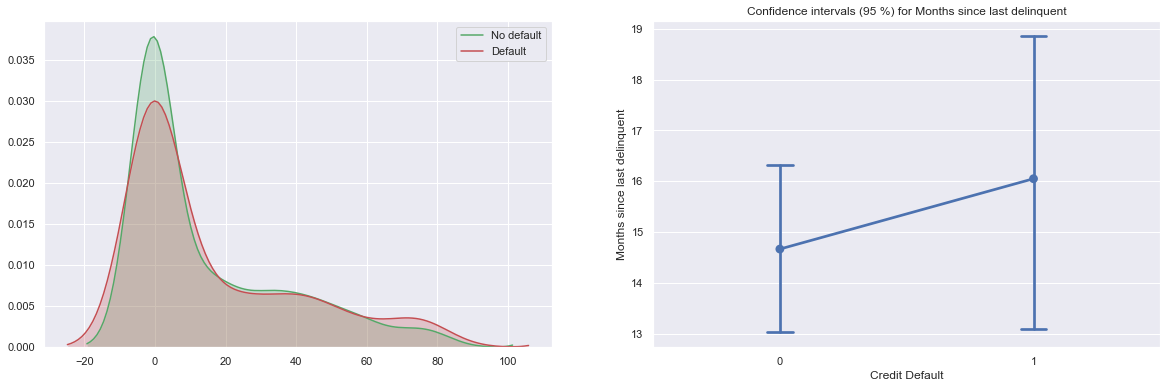

---------------------------Current Loan Amount--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


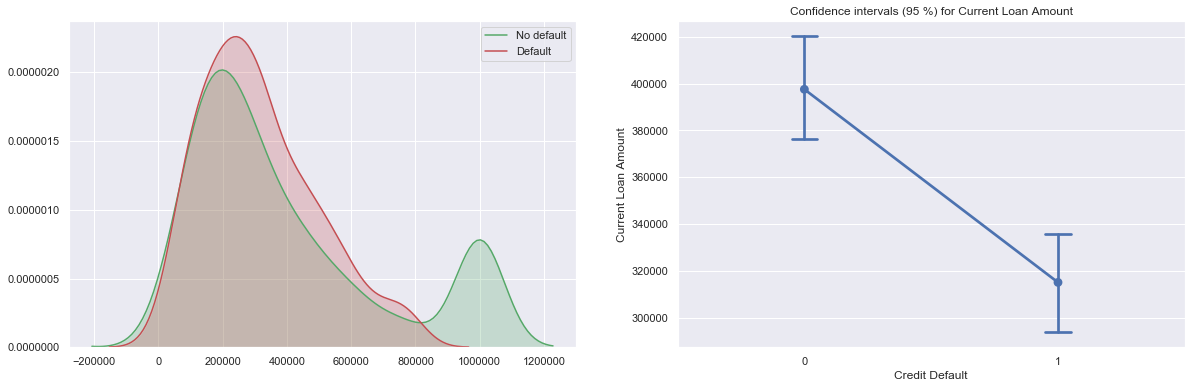

---------------------------Current Credit Balance--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


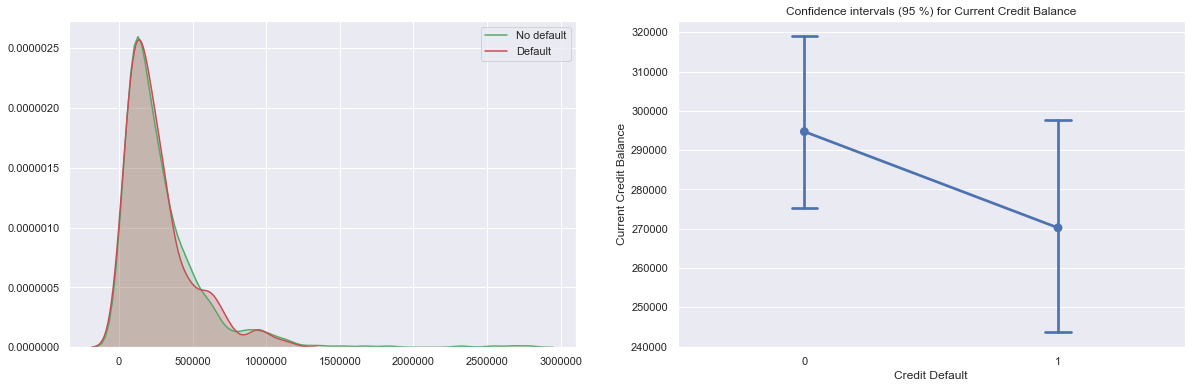

---------------------------Monthly Debt--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


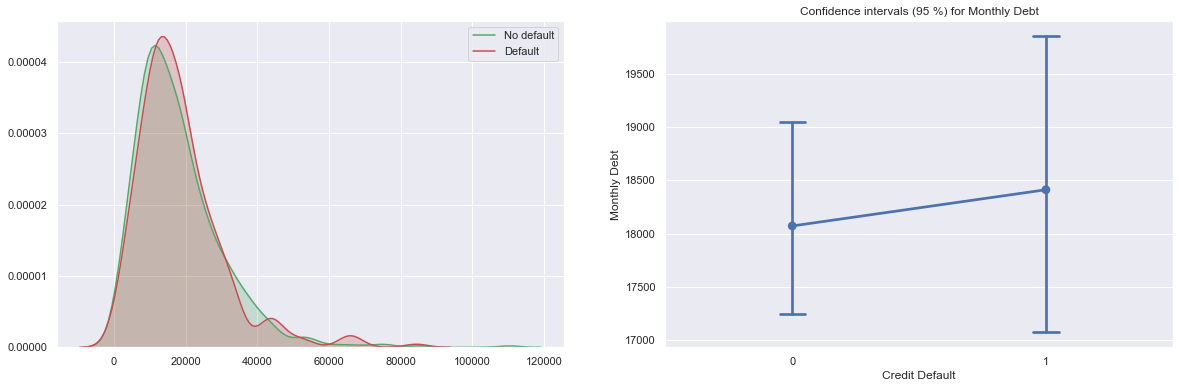

---------------------------Credit Score--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


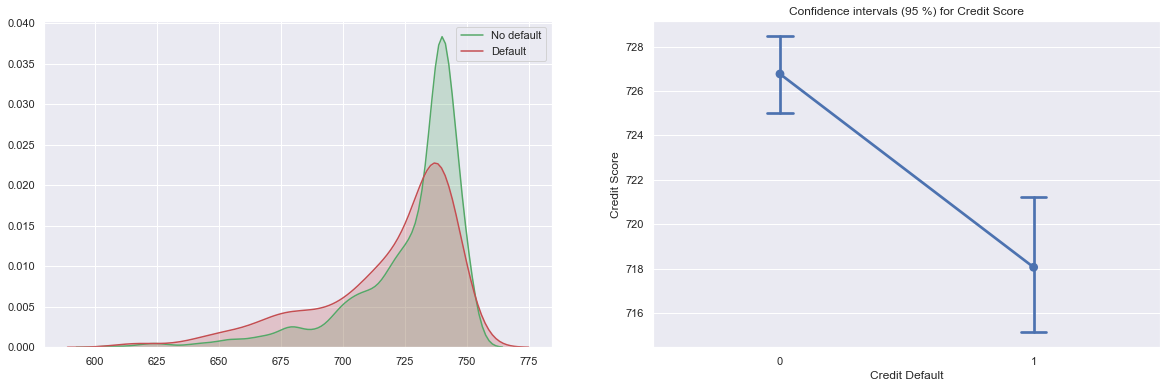

In [29]:
for col in num_features:
    print(f'---------------------------{col}--------------------')
    dist_checker(df, col)
    


Результаты теста Мана-Уитни подтверждаются доверительными интервалами. В случаем их непересечения, H0 нельзя принять, считаем, что мат.ожидания выборок признака сгруппированных по значению таргета не равны. Это справедливо для Признаков Annual Income, Maximum Open Credit, Current Loan Amount, Credit Score, поэтому можем их считать наиболее значимыми для модели.

In [30]:
y = df['Credit Default']
X = df[df.columns.drop(target_name).tolist()]

In [31]:
# преобразовываем категориальные признаки в dummy признаки
for cat_colname in X[cat_features_names]:
    X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)

In [32]:
X.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years_in_cur_job_int', 'ID', 'Term_bool',
       'Home Ownership_Have Mortgage', 'Years_in_cur_job_int_9',
       'Bankruptcies_4.0', 'Number of Credit Problems_7.0',
       'Purpose_major purchase', 'Purpose_renewable energy',
       'Purpose_vacation', 'Term_Long Term', 'Term_Short Term',
       'Tax Liens_3.0', 'Tax Liens_7.0'],
      dtype='object')

In [34]:
X = X[['Annual Income', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years_in_cur_job_int', 'ID', 'Term_bool',
       'Home Ownership_Have Mortgage', 'Years_in_cur_job_int_9',
       'Bankruptcies_4.0', 'Number of Credit Problems_7.0',
       'Purpose_major purchase', 'Purpose_renewable energy',
       'Purpose_vacation', 'Term_Long Term', 'Term_Short Term',
       'Tax Liens_3.0', 'Tax Liens_7.0']]

### 8. Обучение модели и кросс-валидация

In [36]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='f1', 
                           cv=KFold(n_splits=7, shuffle=True, random_state=42))
mean = cv_score.mean()
std = cv_score.std()

print('f1: {:.3f} +- {:.3f}'.format(mean, std))
print(cv_score)

model.fit(X, y)

f1: 0.291 +- 0.033
[0.24460432 0.34375    0.31026253 0.24873096 0.28571429 0.30769231
 0.29716981]


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [37]:
y_scores = model.predict(X)

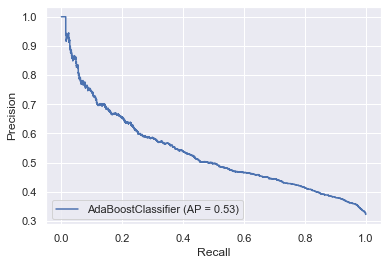

In [38]:
curve = plot_precision_recall_curve(model, X, y)

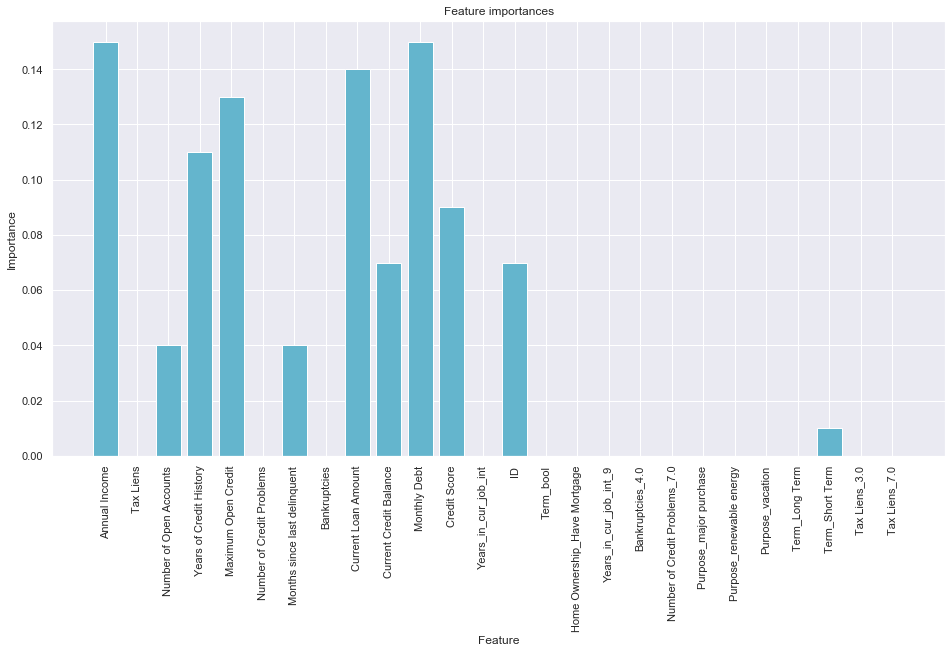

In [39]:
importances = model.feature_importances_
plt.figure(figsize = [16, 8])
plt.bar(X.columns, importances, color='c')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.show()